In [30]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

# 클래스 이름 줄이기
class_names = [x.split('.')[-1] if 'misc' not in x else '.'.join(x.split('.')[-2:]) for x in newsgroups_train.target_names]

print(class_names)

class_names[3] = 'pc.hardware'
class_names[4] = 'mac.hardware'

print(class_names)

['atheism', 'graphics', 'ms-windows.misc', 'hardware', 'hardware', 'x', 'misc.forsale', 'autos', 'motorcycles', 'baseball', 'hockey', 'crypt', 'electronics', 'med', 'space', 'christian', 'guns', 'mideast', 'politics.misc', 'religion.misc']
['atheism', 'graphics', 'ms-windows.misc', 'pc.hardware', 'mac.hardware', 'x', 'misc.forsale', 'autos', 'motorcycles', 'baseball', 'hockey', 'crypt', 'electronics', 'med', 'space', 'christian', 'guns', 'mideast', 'politics.misc', 'religion.misc']


In [31]:
import sklearn
import sklearn.metrics
from sklearn.naive_bayes import MultinomialNB

# TF-IDF를 사용해서 문서를 숫자 벡터로 변환하는 전처리 과정
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

# 학습하기
nb = MultinomialNB(alpha=.01)
nb.fit(train_vectors, newsgroups_train.target)

# 테스트 하기
pred = nb.predict(test_vectors)
sklearn.metrics.f1_score(newsgroups_test.target, pred, average='weighted')

0.8350184193998174

In [32]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(vectorizer, nb)

predict_classes = pipe.predict_proba([newsgroups_test.data[0]]).round(3)[0]

print(predict_classes)

[0.001 0.01  0.003 0.047 0.006 0.002 0.003 0.521 0.022 0.008 0.025 0.
 0.331 0.003 0.006 0.    0.003 0.    0.001 0.009]


In [33]:
rank = sorted(range(len(predict_classes)), 
              key=lambda i: predict_classes[i], 
              reverse=True)
for rank_index in rank:
    print('[{:>5}]\t{:<3}\tclass ({:.1%})'.format(rank.index(rank_index) + 1, rank_index, predict_classes[rank_index]))

[    1]	7  	class (52.1%)
[    2]	12 	class (33.1%)
[    3]	3  	class (4.7%)
[    4]	10 	class (2.5%)
[    5]	8  	class (2.2%)
[    6]	1  	class (1.0%)
[    7]	19 	class (0.9%)
[    8]	9  	class (0.8%)
[    9]	4  	class (0.6%)
[   10]	14 	class (0.6%)
[   11]	2  	class (0.3%)
[   12]	6  	class (0.3%)
[   13]	13 	class (0.3%)
[   14]	16 	class (0.3%)
[   15]	5  	class (0.2%)
[   16]	0  	class (0.1%)
[   17]	18 	class (0.1%)
[   18]	11 	class (0.0%)
[   19]	15 	class (0.0%)
[   20]	17 	class (0.0%)


In [34]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=class_names)

In [35]:
exp = explainer.explain_instance(newsgroups_test.data[0], 
                                 pipe.predict_proba, 
                                 top_labels=1)

exp.available_labels()

split() requires a non-empty pattern match.


[7]

In [36]:
exp.show_in_notebook(text=newsgroups_test.data[0])

In [37]:
from lime.lime_text import LimeTextExplainer

idx = 5

explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(newsgroups_test.data[idx], pipe.predict_proba, top_labels=1)

predict_classes = pipe.predict_proba([newsgroups_test.data[idx]]).round(3)[0]
rank = sorted(range(len(predict_classes)), 
              key=lambda i:predict_classes[i], 
              reverse=True)

print('Document id: %d' % idx)
print('Predicted class: %s' % class_names[nb.predict(test_vectors[idx]).reshape(1, -1)[0, 0]])
print('True class: %s' % class_names[newsgroups_test.target[idx]])
print(predict_classes)
print(rank)

print('Explanation for class %s' % class_names[rank[0]])
print('\n'.join(map(str, exp.as_list(rank[0]))))

exp.show_in_notebook(text=newsgroups_test.data[idx])

split() requires a non-empty pattern match.


Document id: 5
Predicted class: med
True class: med
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[13, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19]
Explanation for class med
('fungus', 0.0017757741241488866)
('infection', 0.0016600382752323991)
('Candida', 0.00164912965675606)
('candida', 0.001534341227548547)
('yeast', 0.0014862841929582649)
('patients', 0.0014764638842348589)
('infections', 0.001430728373829396)
('physicians', 0.001198764949120608)
('B12', 0.0003228816845508767)
('as', 0.00011053352649177553)


# LIME for Image

### scikit-image 패키지를 사용해서 올리베티 얼굴 데이터를 로드하고 확인하는 코드

(-0.5, 1279.5, 1279.5, -0.5)

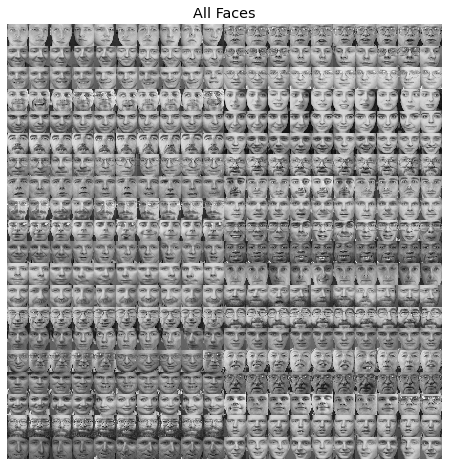

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray
from skimage.util import montage

from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces()

# 이미지를 흑백으로 만들고 LIME이 처리할 수 있는 형태로 변환하기
X_vec = np.stack([gray2rgb(iimg) for iimg in faces.data.reshape((-1, 64, 64))], 0)
y_vec = faces.target.astype(np.uint8)

%matplotlib inline
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
ax1.imshow(montage(X_vec[:, :, :, 0]), 
           cmap='gray', 
           interpolation='none')
ax1.set_title('All Faces')
ax1.axis('off')


### 이미지 한장을 그리는 코드

(-0.5, 63.5, 63.5, -0.5)

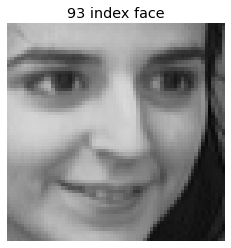

In [39]:
index = 93
plt.imshow(X_vec[index], cmap='gray')
plt.title('{} index face'.format(index))
plt.axis('off')

## 학습하기

sklearn 패키지에 있는 train_test_split 함수를 사용하여 X_vec과 y_vec으로부터 학습용과 테스트용 데이터셋을 분리하는 코드

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec, 
                                                    y_vec, 
                                                    train_size=0.70)

### MLP가 학습할 수 있게 이미지 전처리를 수행하는 파이프라인 생성

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

class PipeStep(object):
    """
        Wrapper for tuning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func = step_func
        
    def fit(self, *args):
        return self
    def transform(self, X):
        return self._step_func(X)
    
makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_pipeline = Pipeline([
    ('Make Gray', makegray_step), 
    ('Flatten Image', flatten_step), 
    ('MLP', MLPClassifier(activation='relu', 
                          hidden_layer_sizes=(400, 40), 
                          random_state=1))
    ])

### 학습 데이터를 MLP가 있는 파이프라인에 입력하는 코드

In [42]:
simple_pipeline.fit(X_train, y_train)

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x7efb4d6d8c18>),
                ('Flatten Image', <__main__.PipeStep object at 0x7efb4d6d8b38>),
                ('MLP',
                 MLPClassifier(hidden_layer_sizes=(400, 40), random_state=1))])

### classification_report를 사용해서 모델 성능을 테스트하는 코드

In [43]:
pipe_pred_test = simple_pipeline.predict(X_test)
pipe_pred_prop = simple_pipeline.predict_proba(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, 
                            y_pred=pipe_pred_test))

              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       1.00      0.50      0.67         4
           2       0.00      0.00      0.00         6
           3       0.50      1.00      0.67         3
           4       0.25      0.50      0.33         2
           5       0.50      0.67      0.57         6
           6       1.00      1.00      1.00         2
           7       1.00      0.50      0.67         6
           8       0.25      0.33      0.29         3
           9       1.00      0.67      0.80         3
          10       0.40      1.00      0.57         2
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00         2
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00         0
          16       1.00      1.00      1.00         3
          17       0.43    

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


## Normalizer 전처리 과정을 추가해서 MLP를 학습시키는 코드

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neural_network import MLPClassifier

class PipeStep(object):
    """
        Wrapper for tuning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func = step_func
        
    def fit(self, *args):
        return self
    
    def transform(self, X):
        return self._step_func(X)
    
makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('Normalize', Normalizer()), # 전처리 과정에 노멀라이저 추가
    ('MLP', MLPClassifier(activation='relu', 
                          hidden_layer_sizes=(400, 40), 
                          random_state=1))
    ])

simple_pipeline.fit(X_train, y_train)

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x7efb4d6d8208>),
                ('Flatten Image', <__main__.PipeStep object at 0x7efb4d6d8390>),
                ('Normalize', Normalizer()),
                ('MLP',
                 MLPClassifier(hidden_layer_sizes=(400, 40), random_state=1))])

### 정규화 추가 후 재학습 결과 확인

In [45]:
pipe_pred_test = simple_pipeline.predict(X_test)
pipe_pred_prop = simple_pipeline.predict_proba(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, 
                            y_pred=pipe_pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      0.50      0.57         4
           2       0.00      0.00      0.00         6
           3       0.50      0.67      0.57         3
           4       0.20      0.50      0.29         2
           5       1.00      0.67      0.80         6
           6       1.00      1.00      1.00         2
           7       1.00      0.83      0.91         6
           8       0.67      0.67      0.67         3
           9       0.50      0.67      0.57         3
          10       1.00      1.00      1.00         2
          11       0.00      0.00      0.00         1
          12       0.33      1.00      0.50         1
          13       1.00      1.00      1.00         2
          14       0.67      0.40      0.50         5
          15       0.00      0.00      0.00         0
          16       0.60      1.00      0.75         3
          17       0.75    

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


### 파라미터 수정하기

In [46]:
simple_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('Normalize', Normalizer()),
    ('MLP', MLPClassifier(
        activation='relu',
        alpha=1e-7,
        epsilon=1e-6,
        hidden_layer_sizes=(800, 120),
        random_state=1))    
])

simple_pipeline.fit(X_train, y_train)

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x7efb4d6d8208>),
                ('Flatten Image', <__main__.PipeStep object at 0x7efb4d6d8390>),
                ('Normalize', Normalizer()),
                ('MLP',
                 MLPClassifier(alpha=1e-07, epsilon=1e-06,
                               hidden_layer_sizes=(800, 120),
                               random_state=1))])

In [47]:
pipe_pred_test = simple_pipeline.predict(X_test)
pipe_pred_prop = simple_pipeline.predict_proba(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, 
                            y_pred=pipe_pred_test))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.75      0.86         4
           2       1.00      0.50      0.67         6
           3       1.00      1.00      1.00         3
           4       0.25      0.50      0.33         2
           5       0.83      0.83      0.83         6
           6       1.00      1.00      1.00         2
           7       1.00      0.83      0.91         6
           8       1.00      0.67      0.80         3
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         1
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00         2
          14       0.80      0.80      0.80         5
          16       1.00      1.00      1.00         3
          17       0.75      1.00      0.86         3
          18       1.00    

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


### LIME의 이미지 설명체와 이미지 분할 알고리즘을 선언하는 코드

In [48]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

exaplainer = lime_image.LimeImageExplainer()

# 이미지 분할 알고리즘: quickshift(기본), slic, felzenszwalb
segmenter = SegmentationAlgorithm('slic', 
                                  n_segments=100, 
                                  compactness=1, 
                                  sigma=1)

### 테스트 0번 이미지에 대해 설명 모델을 구축하는 코드

In [49]:
%%time

olivetti_test_index = 0
print(np.float64(X_test[olivetti_test_index]))

exp = explainer.explain_instance(np.float64(X_test[olivetti_test_index]), 
                                 top_labels=6, 
                                 num_samples=10000, 
                                #  segmentation_fn=segmenter,
                                 classifier_fn=simple_pipeline.predict_proba,
                                 ) 

split() requires a non-empty pattern match.


[[[0.09090909 0.09090909 0.09090909]
  [0.13636364 0.13636364 0.13636364]
  [0.17768595 0.17768595 0.17768595]
  ...
  [0.85537189 0.85537189 0.85537189]
  [0.80165291 0.80165291 0.80165291]
  [0.67355371 0.67355371 0.67355371]]

 [[0.14462809 0.14462809 0.14462809]
  [0.19834711 0.19834711 0.19834711]
  [0.2107438  0.2107438  0.2107438 ]
  ...
  [0.82644629 0.82644629 0.82644629]
  [0.85537189 0.85537189 0.85537189]
  [0.75619835 0.75619835 0.75619835]]

 [[0.20247933 0.20247933 0.20247933]
  [0.21900827 0.21900827 0.21900827]
  [0.22727273 0.22727273 0.22727273]
  ...
  [0.80578512 0.80578512 0.80578512]
  [0.85123968 0.85123968 0.85123968]
  [0.86363637 0.86363637 0.86363637]]

 ...

 [[0.15289256 0.15289256 0.15289256]
  [0.16942149 0.16942149 0.16942149]
  [0.14876033 0.14876033 0.14876033]
  ...
  [0.71487606 0.71487606 0.71487606]
  [0.70661157 0.70661157 0.70661157]
  [0.75619835 0.75619835 0.75619835]]

 [[0.16115703 0.16115703 0.16115703]
  [0.15289256 0.15289256 0.15289256]


TypeError: cannot use a string pattern on a bytes-like object

## 실습#5: 보스턴 주택 가격 결정 요소 구하기
### SHAP 모듈로부터 보스턴 데이터셋을 불러와서 학습용과 테스트용 데이터셋으로 분리하는 코드

In [50]:
import shap
from sklearn.model_selection import train_test_split

X, y = shap.datasets.boston()
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=1)
X_train[:10]

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS   RAD    TAX  \
42    0.14150   0.0   6.91   0.0  0.448  6.169   6.6  5.7209   3.0  233.0   
58    0.15445  25.0   5.13   0.0  0.453  6.145  29.2  7.8148   8.0  284.0   
385  16.81180   0.0  18.10   0.0  0.700  5.277  98.1  1.4261  24.0  666.0   
78    0.05646   0.0  12.83   0.0  0.437  6.232  53.7  5.0141   5.0  398.0   
424   8.79212   0.0  18.10   0.0  0.584  5.565  70.6  2.0635  24.0  666.0   
160   1.27346   0.0  19.58   1.0  0.605  6.250  92.6  1.7984   5.0  403.0   
185   0.06047   0.0   2.46   0.0  0.488  6.153  68.8  3.2797   3.0  193.0   
101   0.11432   0.0   8.56   0.0  0.520  6.781  71.3  2.8561   5.0  384.0   
268   0.54050  20.0   3.97   0.0  0.575  7.470  52.6  2.8720   5.0  264.0   
173   0.09178   0.0   4.05   0.0  0.510  6.416  84.1  2.6463   5.0  296.0   

     PTRATIO       B  LSTAT  
42      17.9  383.37   5.81  
58      19.7  390.68   6.86  
385     20.2  396.90  30.81  
78      18.7  386.40  12.34  
424     20.2    3.65  17.16  
160     14.7  338.92   5.50  
185     17.8  387.11  13.15  
101     20.9  395.58   7.67  
268     13.0  390.30   3.16  
173     16.6  395.50   9.04

### 방의 개수와 집값 간의 관계를 산점도로 그리는 코드

Text(0, 0.5, 'MEDV \n Price $1,000')

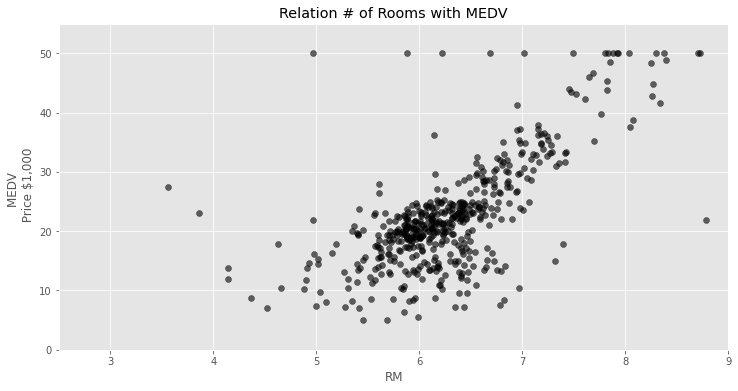

In [51]:
# 산점도 출력 코드
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

ax1.scatter(X['RM'], y, color='black', alpha=0.6)

ax1.set_title('Relation # of Rooms with MEDV')
ax1.set_xlim(2.5, 9)
ax1.set_xlabel('RM')
ax1.set_ylim(0, 55)
ax1.set_ylabel('MEDV \n Price $1,000')

### 선형 모델을 이용해서 방 개수와 주택 가격 간의 관계를 구하는 코드

In [52]:
from sklearn import linear_model
import pandas as pd

linear_regression = linear_model.LinearRegression()
linear_regression.fit(X=pd.DataFrame(X_train['RM']), y=y_train)
prediction = linear_regression.predict(X=pd.DataFrame(X_test['RM']))

print('a value: ', linear_regression.intercept_)
print('b value: ', linear_regression.coef_)
print('MEDV = {:.2f} * RM {:.2f}'.format(linear_regression.coef_[0], linear_regression.intercept_))

a value:  -32.39552264560753
b value:  [8.76050748]
MEDV = 8.76 * RM -32.40


### 방의 개수가 달라질 때 주택 매매 가격을 예측하는 그래프와 데이터를 한꺼번에 플롯으로 그리는 코드

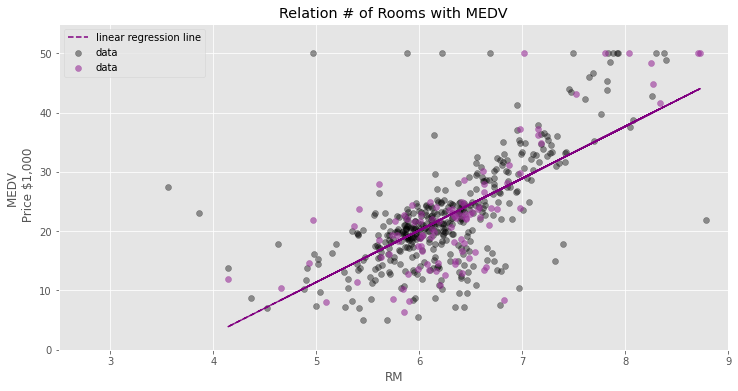

In [53]:
# 학습, 테스트 데이터를 산점도로 그리고 직선의 방정식을 표시하는 코드
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.scatter(X_train['RM'], y_train, color='black', alpha=0.4, label='data')
ax1.scatter(X_test['RM'], y_test, color='#993299', alpha=0.6, label='data')
ax1.set_title('Relation # of Rooms with MEDV')
ax1.set_xlim(2.5, 9)
ax1.set_xlabel('RM')
ax1.set_ylim(0, 55)
ax1.set_ylabel('MEDV \n Price $1,000')

ax1.plot(X_test['RM'], prediction, color='purple', alpha=1, linestyle='--', label='linear regression line')
ax1.legend()

### 모델 예측치와 실제 집값 간의 RMSE를 구하는 코드

In [62]:
import numpy as np
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, prediction, squared=False))

print("RMSE: %f" % (rmse))

RMSE: 2.526487


### xgboost의 선형 회귀 모델로 주택 매매 가격을 예측하는 모델을 만들고 학습하는 코드

In [55]:
import xgboost

# XGBoost 모델 학습하기
model = xgboost.XGBRegressor(objective='reg:linear')
model.fit(X_train, y_train)

preds = model.predict(X_test)

[02:16:02] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


### 전체 피처를 사용해서 학습시킨 모델의 RMSE를 구하는 코드

In [65]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("RMSE: %f" % (rmse))

RMSE: 3.006564


## XAI 적용하기
### SHAP의 설명체를 정의하고 섀플리 값을 계산하는 로직

In [67]:
# JS 시각화 라이브러리 로드하기
shap.initjs()

# SHAP 값으로 모델의 예측을 설명하기
# 설명체는 LightGBM, CatBoost, scikit-laern 모델을 입력받을 수 있다.
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# 첫 번째 데이터에 대한 구체적 SHAP 값 시각화
shap.force_plot(explainer.expected_value, 
                shap_values[0, :], 
                X_train.iloc[0, :])

### 259번 데이터에 대해서 방의 개수(RM)와 집 가격(MEDV)이 어떤 관계가 있는지 플롯으로 그리는 코드

Text(0, 0.5, 'MEDV \n Price $1,000')

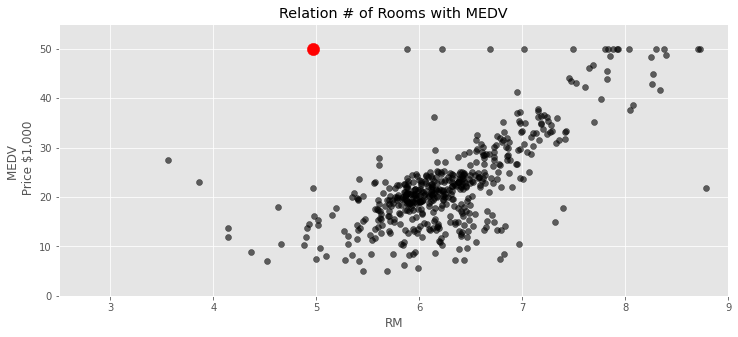

In [69]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))
idx = 259
ax1.scatter(X['RM'], y, color='black', alpha=0.6)
ax1.scatter(X_train['RM'].iloc[idx], y_train[idx], c='red', s=150)
ax1.set_title('Relation # of Rooms with MEDV')
ax1.set_xlim(2.5, 9)
ax1.set_xlabel('RM')
ax1.set_ylim(0, 55)
ax1.set_ylabel('MEDV \n Price $1,000')

### 데이터 259번에 대한 섀플리 영향도를 그리는 코드

In [70]:
shap.force_plot(explainer.expected_value, 
                shap_values[259, :], 
                X_train.iloc[259, :])

### 전체 데이터에 대한 섀플리 값을 플롯으로 그리는 코드

In [71]:
shap.force_plot(explainer.expected_value, shap_values, X_train)

### 방 개수 피처가 집값에 미치는 섀플리 영향도를 시각화하는 플롯

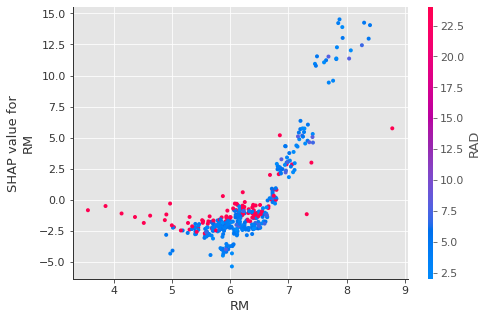

In [72]:
shap.dependence_plot('RM', shap_values, X_train)

### 전체 피처들이 섀플리 값 결정에 어떻게 관여하는지 시각화하는 코드

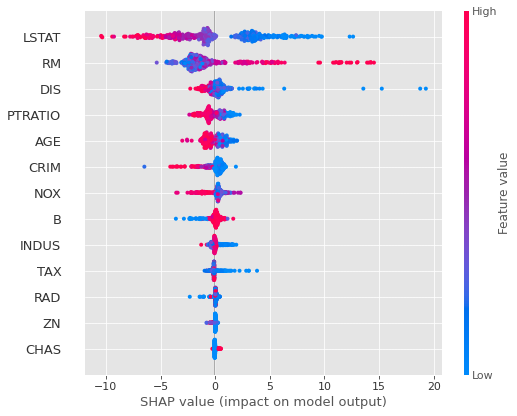

In [74]:
# 모든 피처에 대해 SHAP 값을 계산하고, 영향력을 시각화하는 코드
shap.summary_plot(shap_values, X_train)

### 피처별 섀플리 값을 막대 타입으로 비교하는 코드

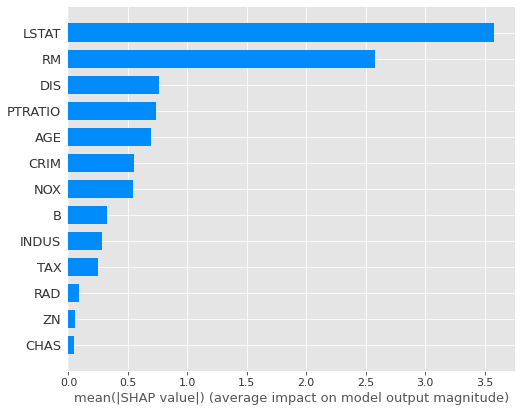

In [75]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

### xgboost의 피처 중요도를 호출하는 코드

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

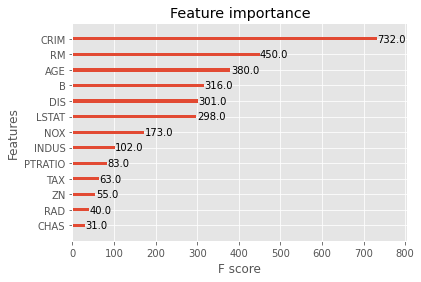

In [76]:
xgboost.plot_importance(model)